# Estimating overhead expenses in VASP calculations
This tutorial describes the issue with overhead expenses in VASP calculations

In [1]:
%rm -rf sandbox/overhead

In [2]:
%mkdir -p sandbox/overhead

In [3]:
%env VASP_COMMAND

'mpirun -np 8 --map-by hwthread /opt/vasp.6.1.2_pgi_mkl_beef/bin/vasp_std'

### Base example of ASE + VASP relaxation
Create a normal, single point `ase.calculators.vasp.Vasp` calculator

In [4]:
from ase.build import molecule
from ase.optimize import BFGS
from ase.calculators.vasp import Vasp
atoms_base = molecule("CH4", pbc=True, vacuum=5)
atoms_base.rattle(0.1)
vasp_params = dict(xc="pbe", kpts=1, encut=350, nsw=1, ibrion=-1)
calc = Vasp(directory="sandbox/overhead", **vasp_params)

Following codes are the standard way to run the relaxation by BFGS optimizer

In [5]:
%%capture out
atoms = atoms_base.copy()    # Avoid overwrite
atoms.calc = calc
dyn = BFGS(atoms)
dyn.run(fmax=0.1)

libibverbs: Warning: couldn't open config directory '/usr/etc/libibverbs.d'.
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    dlopen failed
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-common-cuda.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    ini file:file not found
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-btl-openib.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
---------------------------------------------

In [6]:
print(out.stdout)

      Step     Time          Energy         fmax
BFGS:    0 02:56:48      -22.827328       12.2022
BFGS:    1 02:56:59      -23.573351        4.3421
BFGS:    2 02:57:09      -23.814358        2.3427
BFGS:    3 02:57:20      -23.907204        1.5573
BFGS:    4 02:57:29      -23.941756        0.6833
BFGS:    5 02:57:38      -23.971885        0.4278
BFGS:    6 02:57:48      -23.991150        0.3614
BFGS:    7 02:57:56      -23.989364        0.2442
BFGS:    8 02:58:05      -23.990127        0.0904



As can be seen each step takes about 10 sec. How much time are used for each ionic loop and overhead?

Check the ionic loop time and real wall-time of last iteration

In [7]:
%%bash
grep "LOOP+" sandbox/overhead/OUTCAR
grep "Total CPU time" sandbox/overhead/OUTCAR
grep "Elapsed time" sandbox/overhead/OUTCAR

     LOOP+:  cpu time    2.3971: real time    2.4488
                  Total CPU time used (sec):        4.953
                         Elapsed time (sec):        7.924


### Examine overhead time in different modes
Now let's test the ionic loop time and overall walltime, with modified procedure to the relaxation

Following functions parses the ionic LOOP+ and CPU time and system time profiles

In [8]:
import re
import numpy as np

def parse_outcar_time(outcar_file):
    """Parse the outcar file for LOOP+, total CPU time and wall time"""
    pattern1 = r"LOOP\+\:\s+cpu\s+time\s+([\d\.]+)\:\s+real\s+time\s+([\d\.]+)$"
    pattern2 = r"Total\s+CPU\s+time\s+used\s+\(sec\)\:\s+([\d\.]+)$"
    pattern3 = r"Elapsed\s+time\s+\(sec\)\:\s+([\d\.]+)$"
    outcar_str = open(outcar_file, "r").read()
    time_loops = [float(m[1]) for m in re.findall(pattern1, outcar_str, re.MULTILINE)]
    time_cpu = [float(m) for m in re.findall(pattern2, outcar_str, re.MULTILINE)]
    time_elaps = [float(m) for m in re.findall(pattern3, outcar_str, re.MULTILINE)]
    return time_loops, time_cpu, time_elaps

def ase_vasp_time_profile(atoms, vasp_params, fmax=0.1):
    """Run ase+vasp relaxation and get time profile for each single step"""
    calc = Vasp(directory="sandbox/overhead", **vasp_params)
    atoms.calc = calc
    dyn = BFGS(atoms)
    time_loops = []
    time_cpu = []
    time_elaps = []
    while True:
        # Force run 1 step calculation
        f = np.abs(atoms.get_forces()).max()
        print(f)
        time_profile = parse_outcar_time("sandbox/overhead/OUTCAR")
        time_loops += time_profile[0]
        time_cpu += time_profile[1]
        time_elaps += time_profile[2]
        if f < fmax:
            break
        dyn.step()
    return time_loops, time_cpu, time_elaps

**Case 1**: single point vasp calculator use random trial wavefunction and do not write WAVECAR

In [9]:
%rm -rf sandbox/overhead/*

In [10]:
%%capture out
# CASE 1
# remove wavefunction writing
new_vasp_params = vasp_params.copy()
new_vasp_params.update(lwave=False, istart=0)
time_prof_1 = ase_vasp_time_profile(atoms_base.copy(), new_vasp_params, fmax=0.1)

libibverbs: Warning: couldn't open config directory '/usr/etc/libibverbs.d'.
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    dlopen failed
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-common-cuda.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    ini file:file not found
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-btl-openib.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
---------------------------------------------

**Case 2**: each single point vasp calculator reads old wavefunction and writes WAVECAR

In [11]:
%rm -rf sandbox/overhead/*

In [12]:
%%capture out
# CASE 2
# force adding the lwave=1 tag to save wavecar
new_vasp_params = vasp_params.copy()
new_vasp_params.update(lwave=True, istart=1)
time_prof_2 = ase_vasp_time_profile(atoms_base.copy(), new_vasp_params, fmax=0.1)

libibverbs: Warning: couldn't open config directory '/usr/etc/libibverbs.d'.
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    dlopen failed
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-common-cuda.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    ini file:file not found
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-btl-openib.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
---------------------------------------------

**Case 3**: use internal vasp optimizer (CG)

In [13]:
%rm -rf sandbox/overhead/*

In [14]:
%%capture out
# CASE 3
new_vasp_params = vasp_params.copy()
new_vasp_params.update(ibrion=2, nsw=10, ediffg=-0.1)
atoms = atoms_base.copy() 
atoms.calc = Vasp(directory="sandbox/overhead", **new_vasp_params)
atoms.get_potential_energy()
time_prof_3 = parse_outcar_time("sandbox/overhead/OUTCAR")

libibverbs: Warning: couldn't open config directory '/usr/etc/libibverbs.d'.
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    dlopen failed
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-common-cuda.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
--------------------------------------------------------------------------
Sorry!  You were supposed to get help about:
    ini file:file not found
But I couldn't open the help file:
    /proj/nv/libraries/Linux_x86_64/openmpi/2020/196907-rel/share/openmpi/help-mpi-btl-openib.txt: No such file or directory.  Sorry!
--------------------------------------------------------------------------
---------------------------------------------

Let's now plot the time usage of different modes

In [15]:
%matplotlib inline

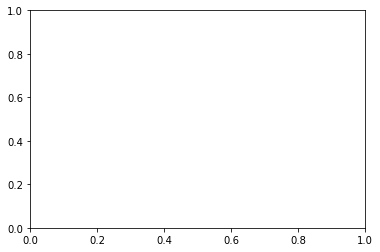

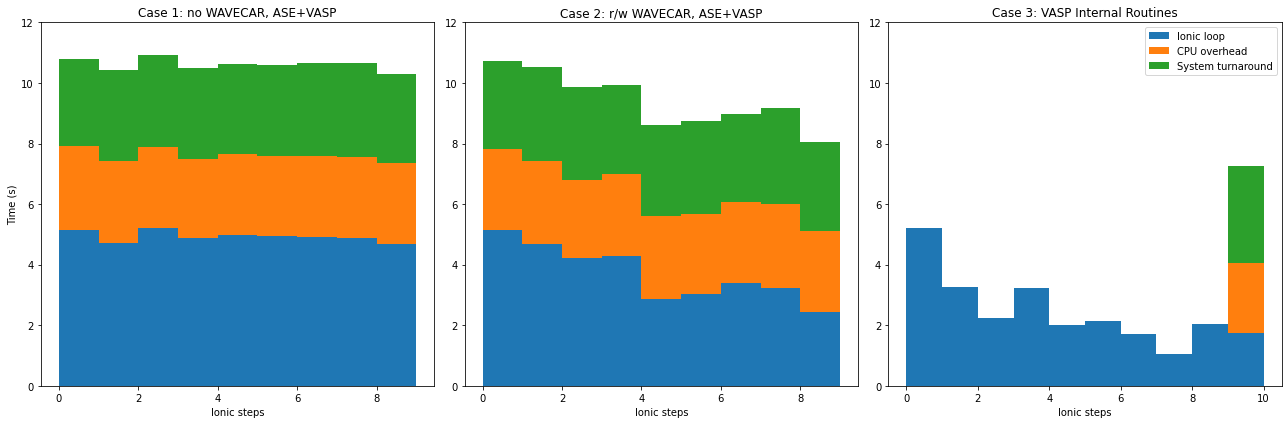

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.cla()
plt.figure(figsize=(18, 6))
# Case 1
plt.subplot(131)
x = range(len(time_prof_1[0]) + 1)
y1 = np.array(time_prof_1[0])
y2 = np.array(time_prof_1[1])
y3 = np.array(time_prof_1[2])
plt.stairs(y1, x, fill=True, zorder=-1)
plt.stairs(y2, x, fill=True, zorder=-2)
plt.stairs(y3, x, fill=True, zorder=-3)
plt.ylim([0, 12])
plt.xlabel("Ionic steps")
plt.ylabel("Time (s)")
plt.title("Case 1: no WAVECAR, ASE+VASP")

# Case 2
plt.subplot(132)
x = range(len(time_prof_2[0]) + 1)
y1 = np.array(time_prof_2[0])
y2 = np.array(time_prof_2[1])
y3 = np.array(time_prof_2[2])
plt.stairs(y1, x, fill=True, zorder=-1)
plt.stairs(y2, x, fill=True, zorder=-2)
plt.stairs(y3, x, fill=True, zorder=-3)
plt.ylim([0, 12])
plt.xlabel("Ionic steps")
plt.title("Case 2: r/w WAVECAR, ASE+VASP")

# Case 3
plt.subplot(133)
x = range(len(time_prof_3[0]) + 1)
y1 = np.array(time_prof_3[0])
y2 = y1.copy()
y2[-1] += time_prof_3[1][0] - np.sum(y1)
y3 = y1.copy()
y3[-1] += time_prof_3[2][0] - np.sum(y1)
plt.stairs(y1, x, fill=True, zorder=-1, label="Ionic loop")
plt.stairs(y2, x, fill=True, zorder=-2, label="CPU overhead")
plt.stairs(y3, x, fill=True, zorder=-3, label="System turnaround")
plt.ylim([0, 12])
plt.xlabel("Ionic steps")
plt.title("Case 3: VASP Internal Routines")
plt.legend()

plt.tight_layout()
plt.savefig("ex00-time-profile.png", dpi=600)